<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/bia/test2/bia_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# exercise 1
import torch
a = torch.tensor([[4, 5], [-2, 1], [0, 6]])
b = torch.tensor([[3, 0, -1], [2, 2, 10]])

print(a.shape)
print(b.shape)

c = b[0] + a@b
x = a[:, 1]
f = -c[0]*(x*x)
f

torch.Size([3, 2])
torch.Size([2, 3])


tensor([ -625,   -10, -1620])

In [ ]:
# exercise 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `nn.Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters
        super().__init__()
        self.hidden = nn.Linear(32, 512)  # Hidden layer
        self.out = nn.Linear(512, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output, based on the input `X`
    def forward(self, X):
        # Note here we use the nn.ReLU class for the ReLU activation function
        return self.out(nn.ReLU()(self.hidden(X)))

In [ ]:
net = MLP()

In [ ]:
import torchvision
from torchvision import transforms

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [7000, 43000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [ ]:
batch_size = 256
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

loss = nn.CrossEntropyLoss()

lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [ ]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
num_epochs = 10
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Training on cuda:0


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [256]

In [ ]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss_all, val_loss_all)

In [ ]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

In [ ]:
# exercise 3

import torchvision
from torchvision import transforms

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR100(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.CIFAR100(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [6000, 44000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [ ]:
class MLP(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels):
        super().__init__()

        self.left_avg = nn.AvgPool2d(kernel_size=2, stride=16)
        self.left_conv = nn.Conv2d(input_channels, 32, kernel_size=1)
        self.left_batch = nn.BatchNorm2d(32)
        self.left_relu = nn.ReLU()

        self.middle_conv = nn.Conv2d(input_channels, 32, kernel_size=1, stride=16)
        self.middle_batch = nn.BatchNorm2d(32)
        self.middle_relu = nn.ReLU()

        self.right_conv = nn.Conv2d(input_channels, 64, kernel_size=1)
        self.right_first_relu = nn.ReLU()

        self.right_conv2 = nn.Conv2d(64, 32, kernel_size=(1, 3), stride = 16)
        self.right_relu2 = nn.ReLU()

        self.right_conv3 = nn.Conv2d(64, 32, kernel_size=(3, 1), stride = 16)
        self.right_relu3 = nn.ReLU()

    def forward(self, X):
        left = self.left_avg(X)
        left = self.left_conv(left)
        left = self.left_batch(left)
        left = self.left_relu(left)

        middle = self.middle_conv(X)
        middle = self.middle_batch(middle)
        middle = self.middle_relu(middle)

        right1 = self.right_conv(X)
        right1 = self.right_first_relu(right1)

        right2 = self.right_conv2(right1)
        right2 = self.right_relu2(right2)

        right3 = self.right_conv3(right1)
        right3 = self.right_relu3(right3)

        out = torch.concat((left, middle, right2, right3), dim=1)
        return out

In [ ]:
net = nn.Sequential(
    MLP(3),
    nn.Flatten(),
    nn.Linear(512, 100)
)

out = MLP(3)(torch.rand((1, 3, 32, 32)))

print(out.shape)

out = nn.Flatten()(out)

print(out.shape)

out = nn.Linear(512, 100)(out)

print(out.shape)

torch.Size([1, 128, 2, 2])
torch.Size([1, 512])
torch.Size([1, 100])


In [ ]:
batch_size = 256
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

loss = nn.CrossEntropyLoss()

lr = 0.05
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

num_epochs = 5
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

# i got Test loss 4.31, Test accuracy 5.37 better than required

100%|██████████| 169M/169M [00:05<00:00, 29.8MB/s]


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified
Training on cuda:0
Epoch 1, Train loss 4.68, Train accuracy 1.03, Validation loss 4.59, Validation accuracy 1.73
Epoch 2, Train loss 4.49, Train accuracy 3.32, Validation loss 4.50, Validation accuracy 3.20
Epoch 3, Train loss 4.38, Train accuracy 4.75, Validation loss 4.40, Validation accuracy 4.39
Epoch 4, Train loss 4.31, Train accuracy 5.92, Validation loss 4.34, Validation accuracy 4.90
Epoch 5, Train loss 4.25, Train accuracy 6.62, Validation loss 4.30, Validation accuracy 5.24
Test loss 4.31, Test accuracy 5.37


In [ ]:
# exercise 4

import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

torch.manual_seed(42);

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('https://s3.amazonaws.com/text-datasets/nietzsche.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 9935
preface
indeed it stands at all for there are scoffers who maintain that it


In [ ]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['preface']
[]
[]
['supposing', 'that', 'truth', 'is', 'a', 'woman', 'what', 'then', 'is', 'there', 'not', 'ground']
['for', 'suspecting', 'that', 'all', 'philosophers', 'in', 'so', 'far', 'as', 'they', 'have', 'been']
['dogmatists', 'have', 'failed', 'to', 'understand', 'women', 'that', 'the', 'terrible']
['seriousness', 'and', 'clumsy', 'importunity', 'with', 'which', 'they', 'have', 'usually', 'paid']
['their', 'addresses', 'to', 'truth', 'have', 'been', 'unskilled', 'and', 'unseemly', 'methods', 'for']
['winning', 'a', 'woman', 'certainly', 'she', 'has', 'never', 'allowed', 'herself', 'to', 'be', 'won', 'and']
['at', 'present', 'every', 'kind', 'of', 'dogma', 'stands', 'with', 'sad', 'and', 'discouraged', 'mien', 'if']
['indeed', 'it', 'stands', 'at', 'all', 'for', 'there', 'are', 'scoffers', 'who', 'maintain', 'that', 'it']


In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(570394, 28)

In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

In [ ]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

In [ ]:
def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('philosophy', 30, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    print(predict('philosophy', 30, net, vocab, device))
    return perplexities

In [ ]:
num_epochs, lr = 350, 3.5
batch_size, num_steps = 32, 35

train_iter, vocab = load_data_time_machine(batch_size, num_steps)

num_hiddens = 30
rnn_layer = nn.RNN(len(vocab), num_hiddens, 3)

device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

perplexities = train(net, train_iter, vocab, lr, num_epochs, device) #1 min

philosophyeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
philosophyt tt tt tt tt tt tt tt tt tt t
philosophy                              
philosophyeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
philosophyseiseiseiseiseiseiseiseiseisei
philosophy ie ie ie ie ie ie ie ie ie ie
philosophy tttt tttt tttt tttt tttt tttt
philosophye esesresesresessesesse esesre
philosophyininininininininininininininin
philosophy                              
philosophyoooooooooooooooooooooooooooooo
philosophyrtrtrtrtrtrtrtrtrtrtrtrtrtrtrt
philosophy                              
philosophy                              
philosophyeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
philosophytttttttttttttttttttttttttttttt
philosophyeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
philosophyoooooooooooooooooooooooooooooo
philosophyrlrlrlrlrlrlrlrlrlrlrlrlrlrlrl
philosophyaoaoaoaoaoaoaoaoaoaoaoaoaoaoao
philosophyeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
philosophyoooooooooooooooooooooooooooooo
philosophy                              
philosophyeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
philosophyssssss

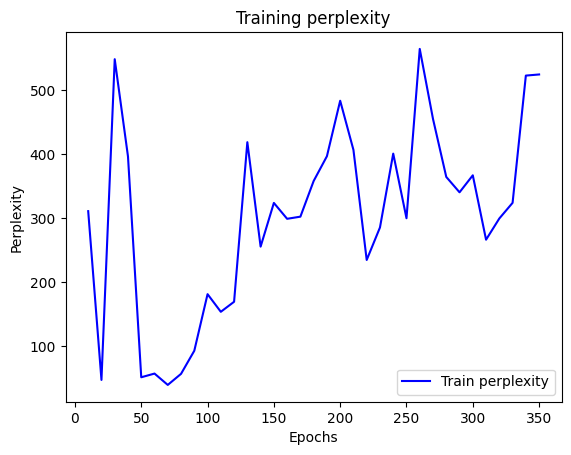

In [ ]:
def plot_perplexity(perplexities):
    epochs = range(10, len(perplexities * 10) + 1, 10)
    plt.plot(epochs, perplexities, 'b', label='Train perplexity')
    plt.title('Training perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()

plot_perplexity(perplexities)

In [ ]:
# exercise 5

def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.sinh(X) @ w + b
    e = torch.normal(0, 0.06, y.shape)
    y += e
    return X, y.reshape(-1, 1)

In [ ]:
true_w = torch.tensor([-3.])
X = torch.normal(0, 1, (1, len(true_w)))
true_b = torch.cosh(X)
features, labels = synthetic_data(true_w, true_b, 150)

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

# Did not find Nadaraya kernel